1. Silent Era (1922–1929)
Key Characteristics: Silent films with live musical accompaniment.
Technological Context: No synchronized sound; dialogue conveyed through intertitles.
Notable Directors: Charlie Chaplin, Buster Keaton, F.W. Murnau.
Iconic Films: Nosferatu (1922), The General (1926).
2. Early Sound Era (1930–1945)
Key Characteristics: Introduction of synchronized sound (the "talkies"), Great Depression, World War II.
Technological Context: Sound recording becomes widespread; black-and-white dominance.
Notable Directors: Frank Capra, Orson Welles, Alfred Hitchcock.
Iconic Films: Gone with the Wind (1939), Citizen Kane (1941).
3. Post-War Golden Age (1946–1959)
Key Characteristics: Rise of color films, Hollywood's Golden Age, introduction of widescreen formats.
Technological Context: Technicolor, CinemaScope, and the rise of television.
Notable Directors: Billy Wilder, Akira Kurosawa, Federico Fellini.
Iconic Films: Sunset Boulevard (1950), Seven Samurai (1954).
4. New Hollywood Era (1960–1980)
Key Characteristics: Creative freedom, experimentation, counter-culture influences.
Technological Context: Emergence of portable cameras and natural lighting.
Notable Directors: Stanley Kubrick, Steven Spielberg, Martin Scorsese.
Iconic Films: 2001: A Space Odyssey (1968), Star Wars (1977).
5. Blockbuster and Digital Transition Era (1981–1999)
Key Characteristics: Rise of blockbusters, CGI breakthroughs, globalization of cinema.
Technological Context: Digital effects, Dolby sound systems, and VHS home viewing.
Notable Directors: James Cameron, Quentin Tarantino, the Coen Brothers.
Iconic Films: Jurassic Park (1993), The Matrix (1999).
6. Modern Cinema and Globalization (2000–2022)
Key Characteristics: Dominance of franchises, streaming services, and global reach of films.
Technological Context: 3D cinema, motion capture, AI, and high-definition visuals.
Notable Directors: Christopher Nolan, Bong Joon-ho, Denis Villeneuve.
Iconic Films: Inception (2010), Parasite (2019).

In [2]:
import pandas as pd
# Set options to display all columns
pd.set_option('display.max_columns', None)  # Show all columns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
from datetime import datetime

C:\Users\Niv.Bar\AppData\Local\Temp\ipykernel_42948\1578829459.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.movies_df['year'].fillna(self.movies_df['year'].mode()[0], inplace=True)


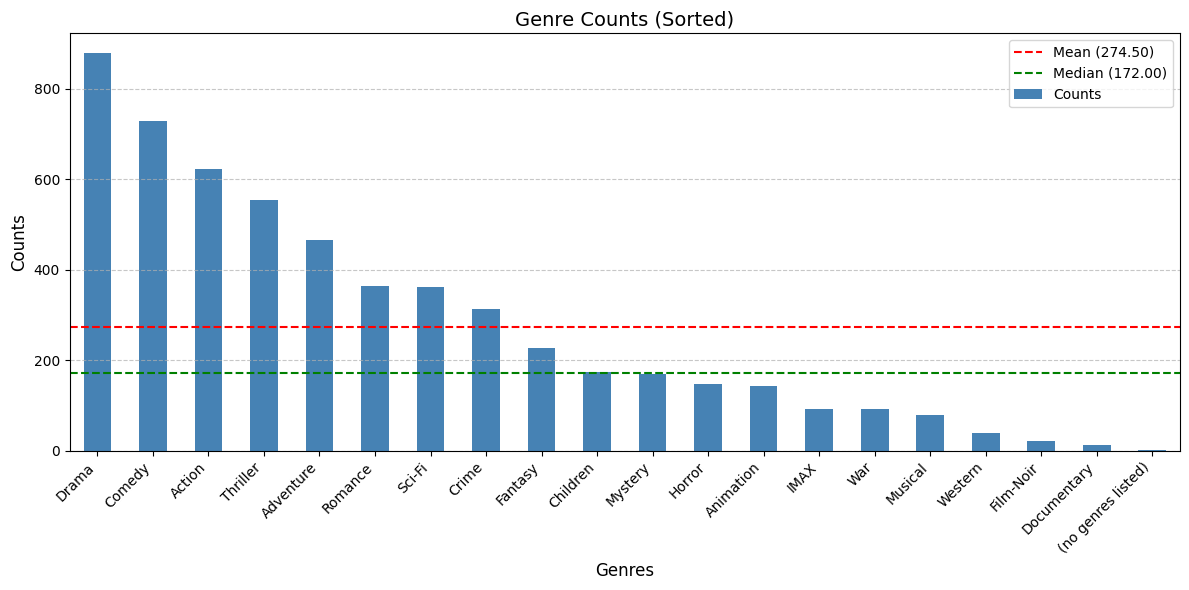

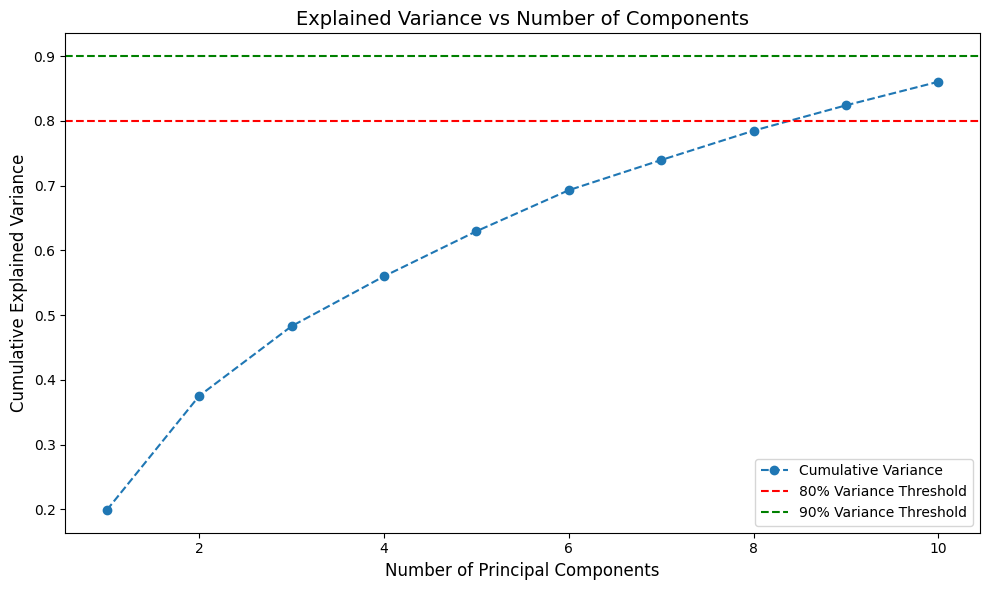

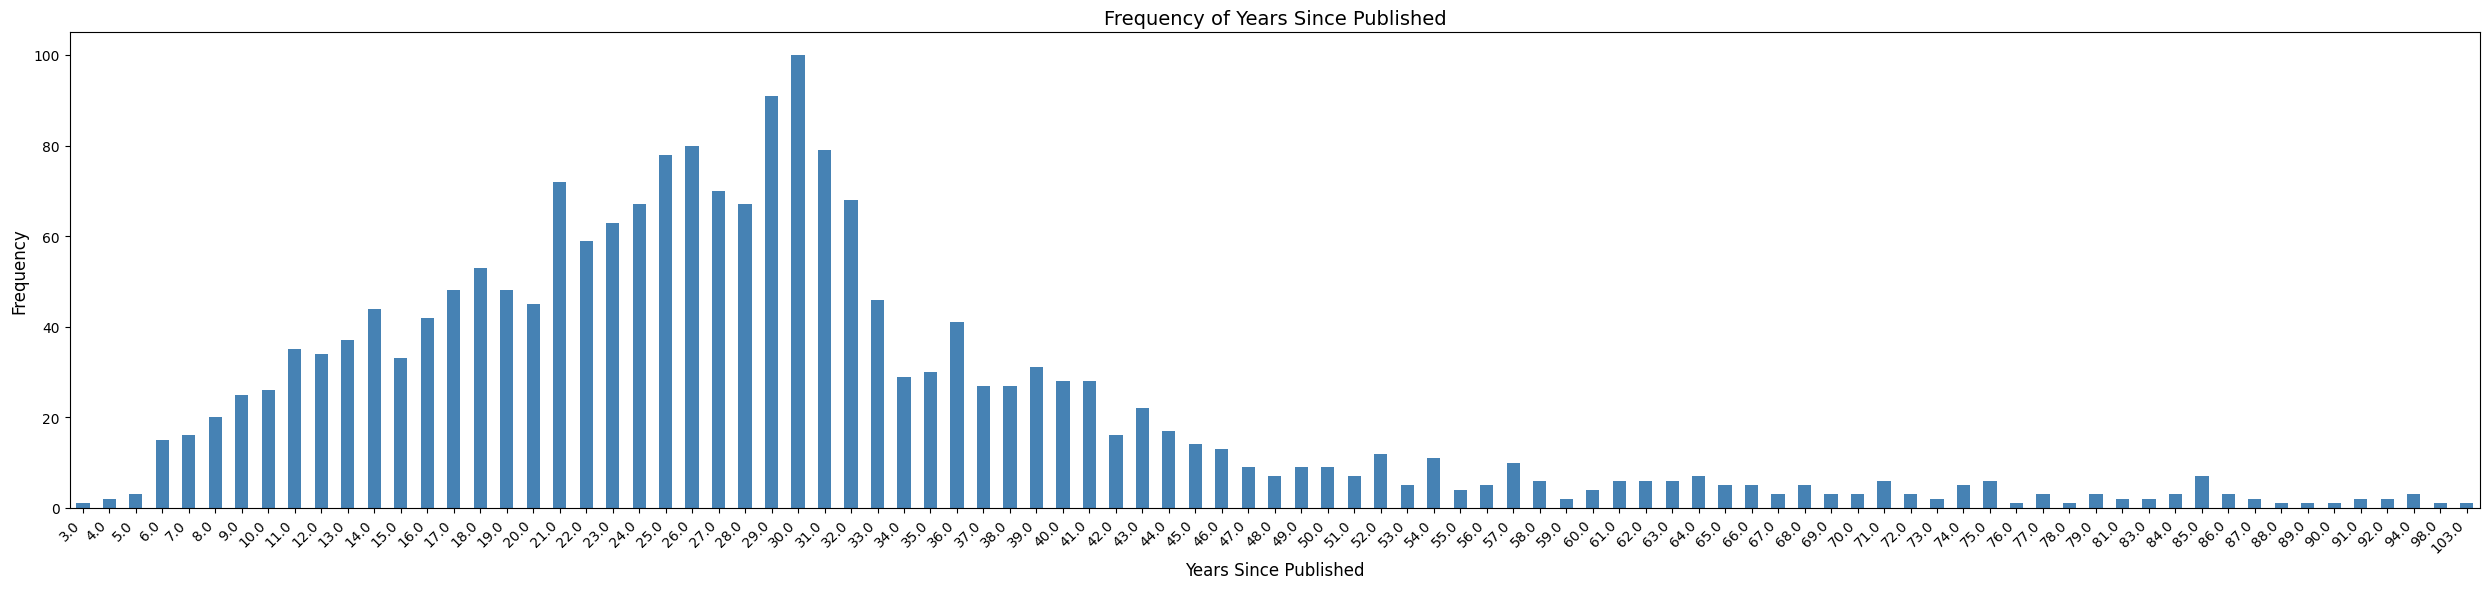

In [2]:
class MovieDataProcessor:
    def __init__(self, file_path=None, genre_columns=None, n_components=None):
        """
        Initialize the MovieDataProcessor.

        Parameters:
        - file_path: Path to the CSV file containing the movie data
        - genre_columns: List of columns representing genres
        - n_components: Number of principal components to retain for PCA (default: all)
        """
        self.file_path = file_path
        self.genre_columns = genre_columns or []
        self.n_components = n_components
        self.movies_df = None

    def read_csv(self):
        """Read the CSV file into a DataFrame."""
        if not self.file_path:
            raise ValueError("File path must be specified to read the CSV.")
        self.movies_df = pd.read_csv(self.file_path)

    def to_csv(self, output_path):
        """Save the processed DataFrame to a CSV file."""
        if self.movies_df is None:
            raise ValueError("No data to save. Process the data first.")
        self.movies_df.to_csv(output_path, index=False)

    def extract_year_from_title(self):
        """Extract the year from the title column."""
        self.movies_df['year'] = self.movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)
        self.movies_df['year'] = pd.to_numeric(self.movies_df['year'], errors='coerce')
        # Fill NaN values in the 'year' column with the mode
        self.movies_df['year'].fillna(self.movies_df['year'].mode()[0], inplace=True)

    def calculate_years_since_published(self):
        """Calculate the number of years since the movie was published."""
        current_year_float = float(datetime.now().year)
        self.movies_df['years_since_published'] = current_year_float - self.movies_df['year']

    def clean_title_column(self):
        """Remove the year from the title column."""
        self.movies_df['title'] = self.movies_df['title'].str.replace(r' \(\d{4}\)$', '', regex=True)

    def process_genres(self):
        """Convert the genres column into dummy variables."""
        genre_dummies = self.movies_df['genres'].str.get_dummies(sep='|').astype(int)
        self.movies_df = pd.concat([self.movies_df, genre_dummies], axis=1)
        self.movies_df.drop(columns=['genres'], inplace=True)

    def add_genre_count_column(self):
        """Add a column to indicate how many genres each movie belongs to."""
        non_genre_columns = ['title', 'year', 'years_since_published', 'processed_year',
                             '(no genres listed)', 'movie_id']
        genre_columns = self.movies_df.columns.difference(non_genre_columns)
        self.movies_df['genre_count'] = self.movies_df[genre_columns].sum(axis=1)

    def genres_occurrence(self):
        """Analyze and visualize genre occurrence statistics."""
        genre_counts = self.movies_df[self.genre_columns].sum()
        genre_mean = genre_counts.mean()
        genre_median = genre_counts.median()
        genre_counts_sorted = genre_counts.sort_values(ascending=False)

        plt.figure(figsize=(12, 6))
        genre_counts_sorted.plot(kind='bar', color='steelblue', label='Counts')
        plt.axhline(y=genre_mean, color='red', linestyle='--', label=f'Mean ({genre_mean:.2f})')
        plt.axhline(y=genre_median, color='green', linestyle='--', label=f'Median ({genre_median:.2f})')
        plt.title('Genre Counts (Sorted)', fontsize=14)
        plt.xlabel('Genres', fontsize=12)
        plt.ylabel('Counts', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def perform_pca_analysis(self):
        """Perform PCA on genre data and visualize explained variance ratio."""
        genre_data = self.movies_df[self.genre_columns]
        pca = PCA(n_components=self.n_components)
        pca_data = pca.fit_transform(genre_data)

        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = explained_variance_ratio.cumsum()

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(explained_variance_ratio) + 1),
                 cumulative_variance_ratio,
                 marker='o', linestyle='--', label='Cumulative Variance')
        plt.axhline(y=0.8, color='red', linestyle='--', label='80% Variance Threshold')
        plt.axhline(y=0.9, color='green', linestyle='--', label='90% Variance Threshold')
        plt.title('Explained Variance vs Number of Components', fontsize=14)
        plt.xlabel('Number of Principal Components', fontsize=12)
        plt.ylabel('Cumulative Explained Variance', fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

        for i in range(pca.n_components_):
            self.movies_df[f'PCA_Component_{i + 1}'] = pca_data[:, i]

    def plot_years_frequency(self):
        """Plot the frequency of movies based on years since publication."""
        years_frequency = self.movies_df['years_since_published'].value_counts().sort_index()
        plt.figure(figsize=(25, 6))
        years_frequency.plot(kind='bar', color='steelblue')
        plt.title('Frequency of Years Since Published', fontsize=14)
        plt.xlabel('Years Since Published', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def categorize_movie_eras(self):
        """Categorize movies into historical eras."""
        bins = [1922, 1930, 1946, 1960, 1981, 2000, 2023]
        labels = ['Silent Era', 'Early Sound Era', 'Post-War Golden Age',
                  'New Hollywood Era', 'Blockbuster Era', 'Modern Cinema']
        self.movies_df['categorized_years'] = pd.cut(self.movies_df['year'], bins=bins, labels=labels, right=False)
        era_mapping = {label: i + 1 for i, label in enumerate(labels)}
        self.movies_df['era_numeric'] = self.movies_df['categorized_years'].map(era_mapping)

    def process(self):
        """Process the entire movie data pipeline."""
        self.extract_year_from_title()
        self.calculate_years_since_published()
        self.clean_title_column()
        self.process_genres()
        self.add_genre_count_column()
        self.genres_occurrence()
        self.perform_pca_analysis()
        self.plot_years_frequency()
        self.categorize_movie_eras()
        return self.movies_df


# Example Usage
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)'
]

processor = MovieDataProcessor(file_path="data/movies.csv", genre_columns=genre_columns, n_components=10)
processor.read_csv()
processed_df = processor.process()
processor.to_csv("data/proceed/movies_proceed.csv")

Tags for 90% coverage: 12435
Tags for 80% coverage: 4575
Tags for 70% coverage: 2112


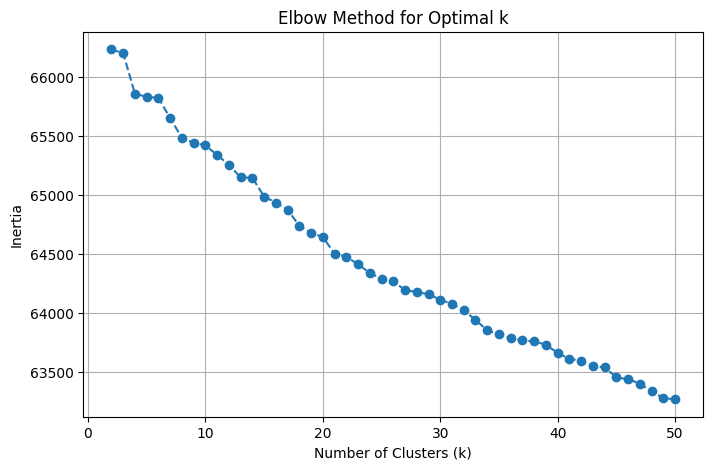

In [3]:
class TagProcessor:
    def __init__(self, file_path=None):
        """
        Initialize the TagProcessor with an optional path to the tags dataset.
        """
        self.file_path = file_path
        self.tags = None
        self.tag_counts = None
        self.tag_clusters = None

    def load_data(self, file_path=None):
        """Load the tags data from a CSV file."""
        if file_path:
            self.file_path = file_path
        if not self.file_path:
            raise ValueError("File path must be provided to load data.")
        self.tags = pd.read_csv(self.file_path)

    def save_data(self, output_path):
        """Save the processed tags DataFrame to a CSV file."""
        if self.tags is None:
            raise ValueError("No data to save. Process the data first.")
        self.tags.to_csv(output_path, index=False)

    def add_movie_tag_count(self):
        """Add a column with the total number of tags for each movie."""
        tag_counts_per_movie = self.tags.groupby('movie_id')['tag'].count()
        self.tags['movie_tag_count'] = self.tags['movie_id'].map(tag_counts_per_movie)

    def add_user_tag_count(self):
        """Add a column with the total number of tags for each user."""
        tag_counts_per_user = self.tags.groupby('user_id')['tag'].count()
        self.tags['user_tag_count'] = self.tags['user_id'].map(tag_counts_per_user)

    def add_unique_movie_tag_count(self):
        """Add a column with the number of unique tags for each movie."""
        unique_tag_counts_per_movie = self.tags.groupby('movie_id')['tag'].nunique()
        self.tags['unique_movie_tag_count'] = self.tags['movie_id'].map(unique_tag_counts_per_movie)

    def add_unique_user_tag_count(self):
        """Add a column with the number of unique tags for each user."""
        unique_tag_counts_per_user = self.tags.groupby('user_id')['tag'].nunique()
        self.tags['unique_user_tag_count'] = self.tags['user_id'].map(unique_tag_counts_per_user)

    def add_avg_user_movie_tags(self):
        """Add a column for the average tags a user gives to unique movies."""
        avg_user_movie_tags = (
            self.tags.groupby(['user_id', 'movie_id']).size().groupby(level=0).mean()
        )
        self.tags['avg_user_movie_tags'] = self.tags['user_id'].map(avg_user_movie_tags)

    def add_avg_movie_user_tags(self):
        """Add a column for the average tags a movie receives from unique users."""
        avg_movie_user_tags = (
            self.tags.groupby(['movie_id', 'user_id']).size().groupby(level=0).mean()
        )
        self.tags['avg_movie_user_tags'] = self.tags['movie_id'].map(avg_movie_user_tags)

    def analyze_sentiment(self):
        """Perform sentiment analysis on tags."""
        def analyze_tag(tag):
            if not isinstance(tag, str) or pd.isna(tag):
                return 0.0, 0.0
            sentiment = TextBlob(tag).sentiment
            return sentiment.polarity, sentiment.subjectivity

        sentiment_scores = self.tags['tag'].apply(lambda x: pd.Series(analyze_tag(x)))
        self.tags['polarity'] = sentiment_scores[0]
        self.tags['subjectivity'] = sentiment_scores[1]

    def add_avg_sentiment_per_movie(self):
        """Add columns for average polarity and subjectivity of tags per movie."""
        avg_polarity_per_movie = self.tags.groupby('movie_id')['polarity'].mean()
        avg_subjectivity_per_movie = self.tags.groupby('movie_id')['subjectivity'].mean()

        self.tags['avg_movie_polarity'] = self.tags['movie_id'].map(avg_polarity_per_movie)
        self.tags['avg_movie_subjectivity'] = self.tags['movie_id'].map(avg_subjectivity_per_movie)

    def add_avg_sentiment_per_user(self):
        """Add columns for average polarity and subjectivity of tags per user."""
        avg_polarity_per_user = self.tags.groupby('user_id')['polarity'].mean()
        avg_subjectivity_per_user = self.tags.groupby('user_id')['subjectivity'].mean()

        self.tags['avg_user_polarity'] = self.tags['user_id'].map(avg_polarity_per_user)
        self.tags['avg_user_subjectivity'] = self.tags['user_id'].map(avg_subjectivity_per_user)

    def calculate_tag_frequencies(self):
        """Calculate unique tags and their frequencies."""
        self.tag_counts = self.tags['tag'].value_counts()

    def calculate_cumulative_percentage(self):
        """Calculate cumulative tag coverage percentage."""
        if self.tag_counts is None:
            self.calculate_tag_frequencies()
        cumulative_percentage = self.tag_counts.cumsum() / self.tag_counts.sum() * 100

        print(f"Tags for 90% coverage: {cumulative_percentage[cumulative_percentage <= 90].count()}")
        print(f"Tags for 80% coverage: {cumulative_percentage[cumulative_percentage <= 80].count()}")
        print(f"Tags for 70% coverage: {cumulative_percentage[cumulative_percentage <= 70].count()}")

    def perform_clustering(self, n_clusters=20):
        """Perform KMeans clustering on tags using TF-IDF vectorization."""
        if self.tag_counts is None:
            self.calculate_tag_frequencies()

        vectorizer = TfidfVectorizer()
        tag_vectors = vectorizer.fit_transform(self.tag_counts.index)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.tag_clusters = kmeans.fit_predict(tag_vectors)

        tag_cluster_mapping = dict(zip(self.tag_counts.index, self.tag_clusters))
        self.tags['cluster'] = self.tags['tag'].map(tag_cluster_mapping)

    def add_unique_user_cluster_count(self):
        """Add a column with the number of unique clusters for each user."""
        unique_cluster_counts_per_user = self.tags.groupby('user_id')['cluster'].nunique()
        self.tags['unique_user_cluster_count'] = self.tags['user_id'].map(unique_cluster_counts_per_user)

    def add_unique_movie_cluster_count(self):
        """Add a column with the number of unique clusters for each movie."""
        unique_cluster_counts_per_movie = self.tags.groupby('movie_id')['cluster'].nunique()
        self.tags['unique_movie_cluster_count'] = self.tags['movie_id'].map(unique_cluster_counts_per_movie)

    def elbow_method(self, max_k=20):
        """Determine the optimal number of clusters using the elbow method."""
        if self.tag_counts is None:
            self.calculate_tag_frequencies()

        vectorizer = TfidfVectorizer()
        tag_vectors = vectorizer.fit_transform(self.tag_counts.index)

        inertia = []
        k_values = range(2, max_k + 1)

        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(tag_vectors)
            inertia.append(kmeans.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(k_values, inertia, marker='o', linestyle='--')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.show()

    def final_clean(self):
        """Clean up the DataFrame by removing unnecessary columns."""
        self.tags.drop(columns=['tag', 'polarity', 'subjectivity', 'cluster'], inplace=True)
        self.tags.drop_duplicates(inplace=True)

    def get_data(self):
        """Return the processed DataFrame."""
        return self.tags


# Example Usage
if __name__ == "__main__":
    processor = TagProcessor()

    # Load the data
    processor.load_data("data/tags.csv")

    # Perform various processing steps
    processor.add_movie_tag_count()
    processor.add_user_tag_count()
    processor.add_unique_movie_tag_count()
    processor.add_unique_user_tag_count()
    processor.add_avg_user_movie_tags()
    processor.add_avg_movie_user_tags()
    processor.analyze_sentiment()
    processor.add_avg_sentiment_per_movie()
    processor.add_avg_sentiment_per_user()
    processor.calculate_cumulative_percentage()
    processor.elbow_method(max_k=50)
    processor.perform_clustering(n_clusters=20)
    processor.add_unique_user_cluster_count()
    processor.add_unique_movie_cluster_count()
    processor.final_clean()

    # Save the processed data
    processor.save_data("data/proceed/tags_proceed.csv")

In [4]:
import pandas as pd

class TrainDataProcessor:
    def __init__(self, file_path=None):
        """
        Initialize the TrainDataProcessor with an optional file path.
        """
        self.file_path = file_path
        self.train_df = None

    def load_data(self, file_path=None):
        """
        Load the training data from a CSV file.
        """
        if file_path:
            self.file_path = file_path
        if not self.file_path:
            raise ValueError("File path must be provided to load data.")
        self.train_df = pd.read_csv(self.file_path)

    def remove_missing_ratings(self):
        """
        Remove rows where the 'rating' column has missing values.
        """
        if self.train_df is None:
            raise ValueError("Data not loaded. Use `load_data` to load the data first.")
        print(self.train_df.shape)
        self.train_df.dropna(subset=['rating'], inplace=True)
        print(self.train_df.shape)

    def add_user_avg_rating(self):
        """
        Add a column indicating the average rating for each unique user_id.
        """
        if self.train_df is None:
            raise ValueError("Data not loaded. Use `load_data` to load the data first.")
        user_avg_ratings = self.train_df.groupby('user_id')['rating'].mean()
        self.train_df['user_avg_rating'] = self.train_df['user_id'].map(user_avg_ratings)

    def add_movie_avg_rating(self):
        """
        Add a column indicating the average rating for each unique movie_id.
        """
        if self.train_df is None:
            raise ValueError("Data not loaded. Use `load_data` to load the data first.")
        movie_avg_ratings = self.train_df.groupby('movie_id')['rating'].mean()
        self.train_df['movie_avg_rating'] = self.train_df['movie_id'].map(movie_avg_ratings)

    def add_rating_counts(self):
        """
        Add columns indicating the number of ratings for each unique movie_id and user_id.
        """
        if self.train_df is None:
            raise ValueError("Data not loaded. Use `load_data` to load the data first.")
        movie_rating_counts = self.train_df.groupby('movie_id')['rating'].count()
        user_rating_counts = self.train_df.groupby('user_id')['rating'].count()
        self.train_df['movie_rating_count'] = self.train_df['movie_id'].map(movie_rating_counts)
        self.train_df['user_rating_count'] = self.train_df['user_id'].map(user_rating_counts)

    def save_data(self, output_path):
        """
        Save the processed training data to a CSV file.
        """
        if self.train_df is None:
            raise ValueError("No data to save. Process the data first.")
        self.train_df.to_csv(output_path, index=False)

    def process(self, input_path=None, output_path="data/proceed/train_proceed.csv"):
        """
        Full processing pipeline for the training data.
        """
        self.load_data(input_path)
        self.remove_missing_ratings()
        self.add_user_avg_rating()
        self.add_movie_avg_rating()
        self.add_rating_counts()
        self.save_data(output_path)
        print(f"Processed data saved to: {output_path}")


# Example Usage
if __name__ == "__main__":
    processor = TrainDataProcessor()
    processor.process(input_path="data/train.csv", output_path="data/proceed/train_proceed.csv")

(18321319, 3)
(7303350, 3)
Processed data saved to: data/proceed/train_proceed.csv


In [29]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class DataMerger:
    def __init__(self, train_path, tags_path, movies_path, output_path):
        """
        Initialize the DataMerger with file paths for the input data and the output file.
        """
        self.train_path = train_path
        self.tags_path = tags_path
        self.movies_path = movies_path
        self.output_path = output_path
        self.train_df = None
        self.tags_df = None
        self.movies_df = None
        self.final_merged_df = None
        self.movies_with_tags_df = None

    def load_data(self):
        """
        Load the input data from the specified file paths.
        """
        self.train_df = pd.read_csv(self.train_path)
        self.tags_df = pd.read_csv(self.tags_path)
        self.movies_df = pd.read_csv(self.movies_path)
        
#         # Filter tags_df to keep only users that exist in train_df
#         self.tags_df = self.tags_df[self.tags_df['user_id'].isin(self.train_df['user_id'])]
#         print(f"Tags DataFrame filtered to {len(self.tags_df)} rows with matching user_ids")

    def filter_movies(self):
        """
        Select relevant columns from the movies DataFrame.
        """
        movies_columns_to_keep = [
            'movie_id', 'years_since_published', 'PCA_Component_1', 'PCA_Component_2',
            'PCA_Component_3', 'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6',
            'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_10',
            'era_numeric'
        ]
        self.movies_df = self.movies_df[movies_columns_to_keep]

    def filter_tags(self):
        """
        Filter relevant columns from the tags DataFrame for movies and users.
        """
        tags_movie_cols = [
            'movie_id', 'movie_tag_count', 'unique_movie_tag_count',
            'avg_movie_user_tags', 'avg_movie_polarity', 'avg_movie_subjectivity',
            'unique_movie_cluster_count'
        ]
        tags_user_cols = [
            'user_id', 'user_tag_count', 'unique_user_tag_count',
            'avg_user_movie_tags', 'avg_user_polarity', 'avg_user_subjectivity',
            'unique_user_cluster_count'
        ]
        
        # Get unique movie and user tags from the filtered tags_df
        self.tags_movie_relevant = self.tags_df[tags_movie_cols].drop_duplicates()
        self.tags_user_relevant = self.tags_df[tags_user_cols].drop_duplicates()
        
        print(f"Unique movie tags shape: {self.tags_movie_relevant.shape}")
        print(f"Unique user tags shape: {self.tags_user_relevant.shape}")

    def merge_movies_with_tags(self):
        """
        First merge: Combine movies_df with tags_movie_relevant
        """
        self.movies_with_tags_df = self.movies_df.merge(
            self.tags_movie_relevant,
            on='movie_id',
            how='left'
        )
        print(f"Movies with tags shape: {self.movies_with_tags_df.shape}")

    def merge_with_train(self):
        """
        Second merge: Combine the movies_with_tags_df with train_df
        """
        # Merge with train data
        self.final_merged_df = self.train_df.merge(
            self.movies_with_tags_df,
            on='movie_id',
            how='left'
        )
        
#         # Then merge with user tags
#         self.final_merged_df = self.final_merged_df.merge(
#             self.tags_user_relevant,
#             on='user_id',
#             how='left'
#         )
        
        print(f"Final merged shape: {self.final_merged_df.shape}")

    def apply_pca(self, data, key_column, n_components=1):
        """
        Apply PCA to the given data and reduce it to specified components.

        Args:
            data (pd.DataFrame): DataFrame to perform PCA on.
            key_column (str): Column to retain as the key for merging.
            n_components (int): Number of principal components to retain.

        Returns:
            pd.DataFrame: DataFrame with the reduced PCA components and the key column.
        """
        data_values = data.drop(columns=[key_column])
        pca = PCA(n_components=n_components)
        pca_components = pca.fit_transform(data_values)
        pca_df = pd.DataFrame(pca_components, columns=[f'PCA_Component_{key_column}'])
        pca_df[key_column] = data[key_column].values
        return pca_df

    def save_final_data(self):
        """
        Save the final merged DataFrame to the specified output path.
        """
        self.final_merged_df.to_csv(self.output_path, index=False)
        print(f"Final merged data saved to: {self.output_path}")

    def get_data(self):
        """
        Return the final merged DataFrame.
        """
        return self.final_merged_df

    def process(self):
        """
        Complete processing pipeline for merging the data.
        """
        print("Starting data processing...")
        self.load_data()
        print("Data loaded successfully")
        
        self.filter_movies()
        print("Movies filtered")
        
        self.filter_tags()
        print("Tags filtered")
        
        self.merge_movies_with_tags()
        print("Movies merged with tags")
        
        self.merge_with_train()
        print("Final merge completed")
        
        self.save_final_data()
        print("Processing completed!")


# Example Usage
if __name__ == "__main__":
    merger = DataMerger(
        train_path="data/proceed/train_proceed.csv",
        tags_path="data/proceed/tags_proceed.csv",
        movies_path="data/proceed/movies_proceed.csv",
        output_path="data/proceed/train_final.csv"
    )
    merger.process()
    
    train_final_df = merger.get_data()

Starting data processing...
Data loaded successfully
Movies filtered
Unique movie tags shape: (2000, 7)
Unique user tags shape: (13253, 7)
Tags filtered
Movies with tags shape: (2000, 19)
Movies merged with tags
Final merged shape: (7303350, 25)
Final merge completed
Final merged data saved to: data/proceed/train_final.csv
Processing completed!


In [30]:
# Step 1: Sample at least one row for each unique user_id
user_sample = train_final_df.groupby('user_id').apply(lambda x: x.sample(n=10)).reset_index(drop=True)

# Step 2: Sample at least one row for each unique movie_id
movie_sample = train_final_df.groupby('movie_id').apply(lambda x: x.sample(n=10)).reset_index(drop=True)

C:\Users\Niv.Bar\AppData\Local\Temp\ipykernel_10460\932554527.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_sample = train_final_df.groupby('user_id').apply(lambda x: x.sample(n=10)).reset_index(drop=True)
C:\Users\Niv.Bar\AppData\Local\Temp\ipykernel_10460\932554527.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movie_sample = train_final_df.groupby('movie_id').apply(lambda x: x.sample(n=10

In [31]:
# Step 3: Combine the two samples with the original DataFrame to retain additional rows
final_df = pd.concat([user_sample, movie_sample]).drop_duplicates()

# Optionally reset the index
final_df = final_df.reset_index(drop=True)

final_df.to_csv("final_df.csv")

final_df

,user_id,movie_id,rating,user_avg_rating,movie_avg_rating,movie_rating_count,user_rating_count,years_since_published,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,era_numeric,movie_tag_count,unique_movie_tag_count,avg_movie_user_tags,avg_movie_polarity,avg_movie_subjectivity,unique_movie_cluster_count
0,0,1212,3.0,2.887019,3.958289,11400,208,54.0,0.347919,1.012193,-0.229297,-0.103916,-0.136390,-0.320837,0.602516,0.699566,-0.029591,0.332612,4,2400,564,6.896552,0.000463,0.192833,18
1,0,51652,4.0,2.887019,3.508637,7757,208,18.0,0.543958,-0.301421,0.299826,0.071057,0.204930,0.203091,-1.106336,-0.175606,-0.293720,0.445772,6,1197,345,5.490826,0.018664,0.141310,12
2,0,45738,4.0,2.887019,3.424983,1453,208,19.0,-0.478051,-0.564367,-0.458364,0.059371,-0.051179,-0.334470,-0.052610,-0.183995,-0.025763,-0.118338,6,305,162,6.489362,-0.027986,0.148800,9
3,0,514,3.0,2.887019,3.094300,5053,208,32.0,-0.478051,-0.564367,-0.458364,0.059371,-0.051179,-0.334470,-0.052610,-0.183995,-0.025763,-0.118338,5,178,69,2.870968,0.021009,0.129494,3
4,0,37,4.0,2.887019,4.082866,18355,208,30.0,0.317995,0.414981,-0.595608,-0.552225,-0.562640,0.150491,0.057814,-0.157756,-0.103424,-0.288910,5,2604,174,5.685590,-0.004190,0.193280,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017544,86291,270688,3.0,3.750000,4.026512,1207,22,3.0,0.410263,-0.715182,-0.299080,0.823774,-0.088505,-0.482961,-0.011504,0.212608,0.126689,0.427573,6,2110,620,12.634731,0.059164,0.148218,12
1017545,91185,270688,3.5,3.363043,4.026512,1207,690,3.0,0.410263,-0.715182,-0.299080,0.823774,-0.088505,-0.482961,-0.011504,0.212608,0.126689,0.427573,6,2110,620,12.634731,0.059164,0.148218,12
1017546,65915,270688,1.5,2.728916,4.026512,1207,83,3.0,0.410263,-0.715182,-0.299080,0.823774,-0.088505,-0.482961,-0.011504,0.212608,0.126689,0.427573,6,2110,620,12.634731,0.059164,0.148218,12
1017547,189113,270688,4.0,3.923963,4.026512,1207,217,3.0,0.410263,-0.715182,-0.299080,0.823774,-0.088505,-0.482961,-0.011504,0.212608,0.126689,0.427573,6,2110,620,12.634731,0.059164,0.148218,12


In [8]:
train_final_df.shape

(7303350, 25)

In [9]:
train_final_df[train_final_df['movie_id'] == 162404]

,user_id,movie_id,rating,user_avg_rating,movie_avg_rating,movie_rating_count,user_rating_count,years_since_published,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,era_numeric,movie_tag_count,unique_movie_tag_count,avg_movie_user_tags,avg_movie_polarity,avg_movie_subjectivity,unique_movie_cluster_count
13109,347,162404,3.5,3.620172,3.773359,1295,233,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
18354,472,162404,3.5,4.102564,3.773359,1295,78,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
18479,480,162404,4.0,3.000000,3.773359,1295,29,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
19734,520,162404,4.0,3.281250,3.773359,1295,32,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
37082,1040,162404,3.5,3.731579,3.773359,1295,285,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245009,199452,162404,3.5,3.510239,3.773359,1295,293,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
7274206,200180,162404,4.0,4.143478,3.773359,1295,115,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
7275895,200223,162404,4.5,4.375000,3.773359,1295,76,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4
7281649,200351,162404,4.5,3.257812,3.773359,1295,192,30.0,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,5,537,82,6.102273,0.124436,0.157767,4


In [10]:
columns_with_nan = train_final_df.columns[train_final_df.isna().any()].tolist()
print("\nColumns containing NaN values:")
print(columns_with_nan)


Columns containing NaN values:
[]


In [11]:
train_final_df.columns

Index(['user_id', 'movie_id', 'rating', 'user_avg_rating', 'movie_avg_rating',
       'movie_rating_count', 'user_rating_count', 'years_since_published',
       'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3',
       'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6',
       'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9',
       'PCA_Component_10', 'era_numeric', 'movie_tag_count',
       'unique_movie_tag_count', 'avg_movie_user_tags', 'avg_movie_polarity',
       'avg_movie_subjectivity', 'unique_movie_cluster_count'],
      dtype='object')

In [16]:
final_df = pd.read_csv("final_df.csv")

In [17]:
movies_to_merge = final_df.drop(columns=['user_id', 'rating', 'user_avg_rating', 'user_rating_count'])
movies_to_merge = movies_to_merge.drop_duplicates(subset=['movie_id'])

user_to_merge = final_df[['user_id', 'rating', 'user_avg_rating', 'user_rating_count']]
user_to_merge = user_to_merge.drop_duplicates(subset=['user_id'])

In [18]:
movies_to_merge

,movie_id,movie_avg_rating,movie_rating_count,years_since_published,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,era_numeric,movie_tag_count,unique_movie_tag_count,avg_movie_user_tags,avg_movie_polarity,avg_movie_subjectivity,unique_movie_cluster_count
0,3862,3.660588,3263,37,-0.122022,-0.456381,-0.732768,0.663972,0.759329,0.578619,-0.207363,0.647413,-0.084029,-0.019365,5,165,42,3.173077,0.004242,0.179697,5
1,1698,4.061960,14711,28,-0.693302,0.516079,0.438237,0.337604,-0.183320,0.494419,-0.103502,0.176054,0.003848,-0.217243,5,2140,139,5.194175,0.189411,0.248524,8
2,345,3.417390,6222,30,-0.753734,-0.593473,-0.413474,0.404874,-0.206834,0.466391,0.005563,0.126936,-0.016454,-0.232997,5,178,52,2.870968,0.090858,0.218590,3
3,5224,3.511668,7628,23,-0.215549,-1.208612,0.283251,-0.825072,0.226195,-0.114467,0.423869,0.078199,0.661193,-0.193191,6,469,208,4.008547,0.028113,0.134090,9
4,366,4.024726,25884,31,-1.078810,0.047573,0.090555,0.595982,0.099058,0.395551,0.193330,-0.110766,0.147868,0.086927,5,3581,748,5.036568,0.130967,0.226238,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29939,59894,2.534398,1221,17,-0.478051,-0.564367,-0.458364,0.059371,-0.051179,-0.334470,-0.052610,-0.183995,-0.025763,-0.118338,6,365,225,7.019231,-0.060440,0.265288,8
30385,2152,3.119477,1109,40,-0.693302,0.516079,0.438237,0.337604,-0.183320,0.494419,-0.103502,0.176054,0.003848,-0.217243,5,47,23,2.136364,0.002128,0.025532,1
34701,36527,3.709160,1714,20,-0.038805,0.887358,-0.039596,-0.240862,-0.201381,0.030535,0.226327,-0.376144,0.252915,0.071121,6,202,92,3.258065,0.053742,0.137135,6
38070,2142,4.034111,1158,59,-0.417618,0.545185,0.393347,-0.007899,-0.027664,-0.306441,-0.161675,-0.134877,-0.005461,-0.102584,4,248,98,5.904762,0.158617,0.175544,3


In [19]:
user_to_merge

,user_id,rating,user_avg_rating,user_rating_count
0,0,3.5,2.887019,208
1,5,5.0,3.630435,23
2,8,5.0,4.190476,21
3,9,4.0,3.523810,63
4,11,2.0,3.775510,49
...,...,...,...,...
99995,200938,4.0,4.154930,71
99996,200953,3.5,3.961538,26
99997,200954,4.0,3.972826,92
99998,200955,0.5,3.202703,37


In [20]:
ratings_submission = pd.read_csv("data/ratings_submission.csv")

In [21]:
ratings_submission

,id,prediction
0,0_1188,0
1,5_7163,0
2,8_460,0
3,9_3705,0
4,11_2650,0
...,...,...
99995,200938_859,0
99996,200953_69751,0
99997,200954_70276,0
99998,200955_33800,0


In [22]:
ratings_submission['user_id'], ratings_submission['movie_id'] = zip(*ratings_submission['id'].str.split('_').apply(lambda x: (int(x[0]), int(x[1]))))

In [23]:
ratings_submission

,id,prediction,user_id,movie_id
0,0_1188,0,0,1188
1,5_7163,0,5,7163
2,8_460,0,8,460
3,9_3705,0,9,3705
4,11_2650,0,11,2650
...,...,...,...,...
99995,200938_859,0,200938,859
99996,200953_69751,0,200953,69751
99997,200954_70276,0,200954,70276
99998,200955_33800,0,200955,33800


In [24]:
sumbission_enriched = ratings_submission.merge(
            movies_to_merge,
            on='movie_id',
            how='left'
        )

sumbission_enriched = sumbission_enriched.merge(
            user_to_merge,
            on='user_id',
            how='left'
        )

In [25]:
sumbission_enriched.drop(columns=['user_id', 'movie_id'], inplace=True)

In [26]:
sumbission_enriched

,id,prediction,movie_avg_rating,movie_rating_count,years_since_published,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,era_numeric,movie_tag_count,unique_movie_tag_count,avg_movie_user_tags,avg_movie_polarity,avg_movie_subjectivity,unique_movie_cluster_count,rating,user_avg_rating,user_rating_count
0,0_1188,0,4.119638,18953,44,0.774766,-0.443173,0.415672,0.135064,0.398060,0.072719,-0.184907,-0.274923,-0.130541,-0.519068,5,1492,461,6.065041,0.070227,0.114060,11,3.5,2.887019,208
1,5_7163,0,4.087343,18433,22,0.467092,-0.014671,1.026013,-0.063476,0.617083,0.285130,-0.138577,-0.423360,-0.505459,0.493016,6,2276,687,6.151351,0.126899,0.175302,11,5.0,3.630435,23
2,8_460,0,3.474900,7271,32,-0.038805,0.887358,-0.039596,-0.240862,-0.201381,0.030535,0.226327,-0.376144,0.252915,0.071121,5,165,50,3.000000,0.010505,0.044949,5,5.0,4.190476,21
3,9_3705,0,3.385235,1490,41,-0.063023,0.116291,1.026374,0.475220,-0.424932,0.342884,0.752489,0.481710,-0.258578,-0.216898,5,65,37,3.823529,0.006758,0.176941,2,4.0,3.523810,63
4,11_2650,0,3.410603,5319,47,1.096429,-0.524709,0.560110,0.456189,-0.071190,-0.233327,0.130203,0.200995,-0.161780,-0.222183,4,218,97,3.303030,0.043941,0.150860,7,2.0,3.775510,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,200938_859,0,2.732890,2484,29,1.475242,-0.182536,0.127167,0.223227,-0.244906,0.103649,0.518205,-0.040273,0.096596,-0.048478,5,39,22,1.950000,-0.074359,0.118590,4,4.0,4.154930,71
99996,200953_69751,0,3.690409,4640,16,-1.070851,0.007354,0.022745,0.521679,0.027002,0.399295,0.295670,0.017405,0.061131,0.135974,6,1297,123,5.315574,0.126121,0.356743,4,3.5,3.961538,26
99997,200954_70276,0,3.783390,7652,16,0.639657,0.333445,-0.451169,-0.231099,-1.031889,-0.155555,0.372925,0.318163,-0.134663,0.007975,6,1834,133,6.302405,0.067848,0.213305,5,4.0,3.972826,92
99998,200955_33800,0,3.904577,12607,20,0.607534,0.037055,-0.276244,0.127918,0.681929,-0.117997,-0.699140,0.591263,-0.179218,-0.183690,6,1138,141,4.626016,0.040759,0.125308,6,0.5,3.202703,37


In [27]:
sumbission_enriched.to_csv("sumbission_enriched.csv")

In [ ]:
# !pip install tensorflow==2.12
# !pip install --upgrade pip setuptools wheel
# !pip install h5py==3.8.0
# !pip install deepctr --no-deps

### Only Raw train and ratings_submission

In [ ]:
import pandas as pd
import numpy as np
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, get_feature_names
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import os

class MovieLensRecommender:
    def __init__(self, data_path):
        self.data_path = data_path
        self.train_df = None
        self.submission_df = None
        self.model = None
        self.feature_columns = None

    def load_data(self):
        self.train_df = pd.read_csv(os.path.join(self.data_path, "train.csv"))
        self.train_df.dropna(subset=['rating'], inplace=True)
        self.submission_df = pd.read_csv(os.path.join(self.data_path, "ratings_submission.csv"))

    def preprocess_data(self):
        le_user = LabelEncoder()
        le_movie = LabelEncoder()

        self.train_df['user_id'] = le_user.fit_transform(self.train_df['user_id'])
        self.train_df['movie_id'] = le_movie.fit_transform(self.train_df['movie_id'])

        self.submission_df['user_id'], self.submission_df['movie_id'] = zip(*self.submission_df['id'].str.split('_').apply(lambda x: (int(x[0]), int(x[1]))))
        self.submission_df['user_id'] = le_user.transform(self.submission_df['user_id'])
        self.submission_df['movie_id'] = le_movie.transform(self.submission_df['movie_id'])

        self.feature_columns = [
            SparseFeat('user_id', vocabulary_size=len(le_user.classes_), embedding_dim=8),
            SparseFeat('movie_id', vocabulary_size=len(le_movie.classes_), embedding_dim=8),
        ]

    def build_model(self):
        self.model = DeepFM(self.feature_columns, self.feature_columns, task='regression')
        self.model.compile("adam", "mse")

    def train_model(self, epochs=5, batch_size=1024):
        train_data, val_data = train_test_split(self.train_df, test_size=0.2, random_state=42)

        train_model_input = {
            'user_id': train_data['user_id'],
            'movie_id': train_data['movie_id']
        }
        val_model_input = {
            'user_id': val_data['user_id'],
            'movie_id': val_data['movie_id']
        }

        train_labels = train_data['rating']
        val_labels = val_data['rating']

        history = self.model.fit(
            train_model_input,
            train_labels,
            validation_data=(val_model_input, val_labels),
            epochs=epochs,
            batch_size=batch_size
        )

        return history

    def wrmse(self, y_true, y_pred, weights):
        numerator = np.sum(weights * (y_true - y_pred) ** 2)
        denominator = np.sum(weights)
        return np.sqrt(numerator / denominator)

    def evaluate_model(self):
        val_data = self.train_df.sample(frac=0.2, random_state=42)
        val_model_input = {
            'user_id': val_data['user_id'],
            'movie_id': val_data['movie_id']
        }
        val_labels = val_data['rating']

        predictions = self.model.predict(val_model_input, batch_size=1024)
        movie_counts = self.train_df.groupby('movie_id')['rating'].count()
        weights = 1 / np.sqrt(movie_counts[val_data['movie_id']].values)

        wrmse_value = self.wrmse(val_labels.values, predictions.flatten(), weights)
        print(f"Validation W-RMSE: {wrmse_value}")

    def predict_submission(self):
        submission_model_input = {
            'user_id': self.submission_df['user_id'],
            'movie_id': self.submission_df['movie_id']
        }

        predictions = self.model.predict(submission_model_input, batch_size=1024)
        self.submission_df['prediction'] = predictions
        self.submission_df[['id', 'prediction']].to_csv(
            os.path.join(self.data_path, "submission.csv"), index=False
        )

    def save_model(self, output_path):
        self.model.save(os.path.join(output_path, "recommender_model"))

if __name__ == "__main__":
    data_path = "./drive/MyDrive/MLDS/recommendation_systems/final_project_kaggle/data/"
    output_path = "./drive/MyDrive/MLDS/recommendation_systems/final_project_kaggle/output/"

    recommender = MovieLensRecommender(data_path)
    recommender.load_data()
    recommender.preprocess_data()
    recommender.build_model()
    history = recommender.train_model(epochs=5, batch_size=1024)

    recommender.evaluate_model()
    recommender.predict_submission()
    recommender.save_model(output_path)


### enriched train and ratings_submission

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import os

class MovieLensRecommender:
    def __init__(self, data_path):
        self.data_path = data_path
        self.train_df = None
        self.submission_df = None
        self.model = None
        self.feature_columns = None

    def load_data(self):
        self.train_df = pd.read_csv(os.path.join(self.data_path, "final_df.csv"))
        self.train_df.dropna(subset=['rating'], inplace=True)
        self.submission_df = pd.read_csv(os.path.join(self.data_path, "sumbission_enriched.csv"))

    def preprocess_data(self):
        le_user = LabelEncoder()
        le_movie = LabelEncoder()

        # Encode user_id and movie_id
        self.train_df['user_id'] = le_user.fit_transform(self.train_df['user_id'])
        self.train_df['movie_id'] = le_movie.fit_transform(self.train_df['movie_id'])

        self.submission_df['user_id'], self.submission_df['movie_id'] = zip(*self.submission_df['id'].str.split('_').apply(lambda x: (int(x[0]), int(x[1]))))
        self.submission_df['user_id'] = le_user.transform(self.submission_df['user_id'])
        self.submission_df['movie_id'] = le_movie.transform(self.submission_df['movie_id'])

        # Scale numerical features
        numeric_features = [
            'user_avg_rating', 'movie_avg_rating',
       'movie_rating_count', 'user_rating_count', 'years_since_published',
       'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3',
       'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6',
       'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9',
       'PCA_Component_10', 'era_numeric', 'movie_tag_count',
       'unique_movie_tag_count', 'avg_movie_user_tags', 'avg_movie_polarity',
       'avg_movie_subjectivity', 'unique_movie_cluster_count'
        ]

        scaler = StandardScaler()
        self.train_df[numeric_features] = scaler.fit_transform(self.train_df[numeric_features])
        self.submission_df[numeric_features] = scaler.transform(self.submission_df[numeric_features])

        # Define feature columns
        self.feature_columns = [
            SparseFeat('user_id', vocabulary_size=len(le_user.classes_), embedding_dim=8),
            SparseFeat('movie_id', vocabulary_size=len(le_movie.classes_), embedding_dim=8)
        ]
        # Add DenseFeat to the imports for numerical features
        self.feature_columns += [
            DenseFeat(feature, 1) for feature in numeric_features
        ]


    def build_model(self):
        self.model = DeepFM(self.feature_columns, self.feature_columns, task='regression')
        self.model.compile("adam", "mse")

    def train_model(self, epochs=20, batch_size=1024):
        train_data, val_data = train_test_split(self.train_df, test_size=0.2, random_state=42)

        train_model_input = {
            'user_id': train_data['user_id'],
            'movie_id': train_data['movie_id'],
            **{feature: train_data[feature] for feature in train_data.columns if feature not in ['user_id', 'movie_id', 'rating']}
        }
        val_model_input = {
            'user_id': val_data['user_id'],
            'movie_id': val_data['movie_id'],
            **{feature: val_data[feature] for feature in val_data.columns if feature not in ['user_id', 'movie_id', 'rating']}
        }

        train_labels = train_data['rating']
        val_labels = val_data['rating']

        history = self.model.fit(
            train_model_input,
            train_labels,
            validation_data=(val_model_input, val_labels),
            epochs=epochs,
            batch_size=batch_size
        )

        return history

    def wrmse(self, y_true, y_pred, weights):
        """
        Calculate Weighted Root Mean Squared Error (W-RMSE).
        Args:
            y_true (np.array): True labels.
            y_pred (np.array): Predicted values.
            weights (np.array): Weights for each sample.
        Returns:
            float: Weighted RMSE.
        """
        mse = np.sum(weights * (y_true - y_pred) ** 2) / np.sum(weights)
        return np.sqrt(mse)

    def evaluate_model(self):
        val_data = self.train_df.sample(frac=0.2, random_state=42)
        val_model_input = {
            'user_id': val_data['user_id'],
            'movie_id': val_data['movie_id'],
            **{feature: val_data[feature] for feature in val_data.columns if feature not in ['user_id', 'movie_id', 'rating']}
        }
        val_labels = val_data['rating']

        predictions = self.model.predict(val_model_input, batch_size=1024)
        movie_counts = self.train_df.groupby('movie_id')['rating'].count()
        weights = 1 / np.sqrt(movie_counts[val_data['movie_id']].values)

        wrmse_value = self.wrmse(val_labels.values, predictions.flatten(), weights)
        print(f"Validation W-RMSE: {wrmse_value}")

    def predict_submission(self):
        submission_model_input = {
            'user_id': self.submission_df['user_id'],
            'movie_id': self.submission_df['movie_id'],
            **{feature: self.submission_df[feature] for feature in self.submission_df.columns if feature not in ['user_id', 'movie_id', 'id']}
        }

        predictions = self.model.predict(submission_model_input, batch_size=1024)
        self.submission_df['prediction'] = predictions
        self.submission_df[['id', 'prediction']].to_csv(
            os.path.join(self.data_path, "submission.csv"), index=False
        )

if __name__ == "__main__":
    data_path = "./drive/MyDrive/MLDS/recommendation_systems/final_project_kaggle/data/"
    output_path = "./drive/MyDrive/MLDS/recommendation_systems/final_project_kaggle/output/"

    recommender = MovieLensRecommender(data_path)
    recommender.load_data()
    recommender.preprocess_data()
    recommender.build_model()
    history = recommender.train_model(epochs=10, batch_size=1024)

    recommender.evaluate_model()
    recommender.predict_submission()
    recommender.save_model(output_path)